In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

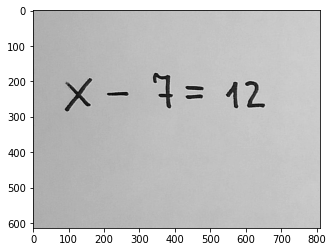

In [61]:
#Loen sisse pildi, grayscale
img = cv.imread('test_images/subtraction.jpg')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

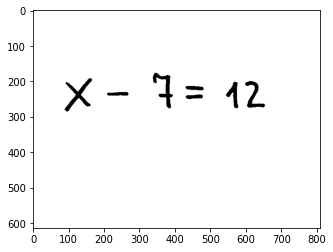

In [24]:
#blurimine vajalik et eemaldada müra
blur_img = cv.GaussianBlur(img_gray,(5,5),0)
#thresholdimisega teeme hallist taustast valge ja tekstist musta
ret, thresh = cv.threshold(blur_img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')

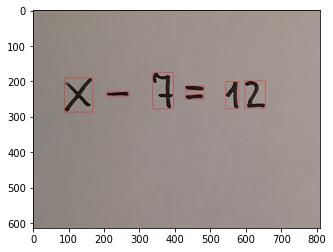

In [97]:
#kontuurid näitavad kus pildil on teksti
contours,hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
boxed_img = img.copy()
individual_boxes = []
for cnt in contours:
    #bounding box võimaldab pärast pildist huvipakkuva tekstiosa välja lõigata
    x,y,w,h = cv.boundingRect(cnt)
    # kui kast ei ole terve pildi suurune siis lisame jälgitavasse
    if w < img_gray.shape[1] and h < img_gray.shape[0]:
        individual_boxes.append([x,y,w,h])
    boxed_img = cv.rectangle(boxed_img,(x,y),(x+w,y+h),(255,0,0),1)

plt.imshow(boxed_img)

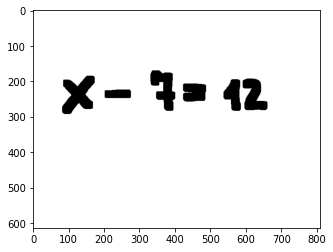

In [80]:
# paksendan jooni kõvasti, et lähedalolevad sümbolid (nt võrdusmärgid) muutuksid üheks
kernel = np.ones((15,15),np.uint8)
thresh_dilate = cv.erode(thresh, kernel, iterations=1)
plt.imshow(thresh_dilate, cmap="gray")

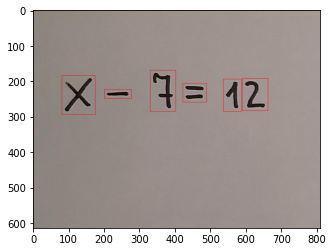

In [81]:
contours,hierarchy = cv.findContours(thresh_dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
boxed_img = img.copy()
joined_boxes = []
for cnt in contours:
    x,y,w,h = cv.boundingRect(cnt)
    # kui kast ei ole terve pildi suurune siis lisame jälgitavasse
    if w < img_gray.shape[1] and h < img_gray.shape[0]:
        joined_boxes.append([x,y,w,h])
    boxed_img = cv.rectangle(boxed_img,(x,y),(x+w,y+h),(255,0,0),1)

plt.imshow(boxed_img)

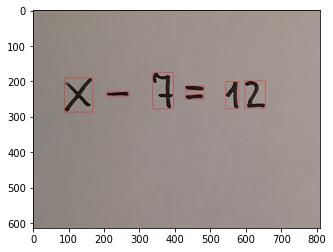

In [98]:
plt.imshow(boxed_img)

In [91]:
#sorteerib kastid nende x koordinaadi väärtuse põhjal
#st. et eeldame et tehe on kirjutatud ühes reas
def order_boxes(boxes):
    boxes.sort(key=lambda x:x[0])

In [84]:
def get_areas(boxes):
    areas = []
    for box in boxes:
        areas.append(box[2]*box[3])
    return areas

In [103]:
order_boxes(individual_boxes)
individual_boxes

[[88, 191, 80, 96],
 [208, 230, 62, 12],
 [337, 176, 58, 102],
 [429, 237, 51, 15],
 [429, 213, 53, 14],
 [543, 201, 37, 77],
 [597, 199, 58, 77]]

In [104]:
areas = get_areas(individual_boxes)
areas

[7680, 744, 5916, 765, 742, 2849, 4466]

In [130]:
#lõikab bounding boxide põhjal välja pildist huvipakkuvad pildid
def get_crops(image, boxes, draw=False):
    crops = []
    for box in boxes:
        x,y,w,h = box
        crops.append(image[y:y+h,x:x+w])
    if draw:
        for i, crop in enumerate(crops):
            plt.subplot(1,len(crops),i+1)
            #plt.axis('off')
            plt.imshow(crop, cmap="gray")
    return crops

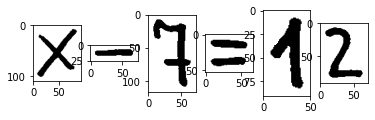

In [131]:
crops = get_crops(thresh, joined_boxes, True)

In [134]:
def draw_crops(crops, draw_axis='on'):
    for i, crop in enumerate(crops):
            plt.subplot(1,len(crops),i+1)
            plt.axis(draw_axis)
            plt.imshow(crop, cmap="gray")

In [155]:
#muudab pildid listis ruudukujuliseks, lisades puhvrit ümber
def make_square(image_list, square_size=None):
    ruudud = []
    for image in image_list:
        h, w = image.shape
        og_square_edge = max(h,w)
        if h > w:
            pool = (h-w)//2
            #vasakule liidetav pilt, laiusega pool, kõrgusega h, värv 255
            vasakule = np.full((h,pool), 255)
            #paremale liidetav pilt, laiusega h-w-pool, kõrgusega h, värv 255
            paremale = np.full((h,h-w-pool), 255)
            ruudud.append(np.concatenate((vasakule,image,paremale), axis=1))
        else:
            pool = (w-h)//2
            #ules liidetav pilt, laiusega w, kõrgusega pool, värv 255
            ules = np.full((pool, w), 255)
            #alla liidetav pilt, laiusega w, kõrgusega w-h-pool, värv 255
            alla = np.full((w-h-pool, w), 255)
            ruudud.append(np.concatenate((ules,image,alla), axis=0))
      
    #vajadusel muudab ruutude suurust
    if square_size != None:
        lopp_ruudud = []
        for image in ruudud:
            lopp_ruudud.append(cv.resize(np.array(image, dtype='uint8'), (square_size, square_size), interpolation=cv.INTER_AREA))
        ruudud = lopp_ruudud
    return ruudud

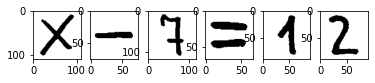

In [151]:
crops = make_square(crops)
draw_crops(crops)

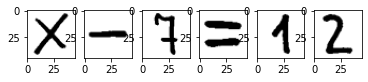

In [156]:
tiny_crops = make_square(crops, 45)
draw_crops(tiny_crops)

# Arvutamine

Siin vahel peaks olema mudeli töötlus, mis võtaks ette nt tiny_crops listi piltidest, ja tagastaks järjekorras mis igal pildil on. Mudeli treenimine mõnes teises failis, siin praegu tegelen test sisendiga.

In [407]:
def find_x(equation_list, eelmine_tehtepool = None, algne = None):
    if algne == None:
        algne = ''.join(equation_list)
    #ühenda täisarvud stringidena
    new_equation_list = []
    for i, element in enumerate(equation_list):
        try:
            #kui liitmistehe õnnestub, siis on tegu numbritega.
            number = int(new_equation_list[-1])+int(element)
            #eelmisele elemendile lisan uue elemendi
            new_equation_list[-1] = new_equation_list[-1]+str(element)
        except:
            #kui ei olnud number, või eelmine ei olnud number, siis lisan uue
            new_equation_list.append(element)
    equation_list = new_equation_list
        
    #panen kokku ühest tehtemärgist teise tehtemärgini, va =
    #esimene märk ei pruugi olla tehtemärk
    tehtemargid = [0]
    for i in range(len(equation_list)):
        if equation_list[i] in ["+","-","/","*"]:
            tehtemargid.append(i)
        #võrdusmärgi peaks teistest eraldama
        if equation_list[i] == "=":
            tehtemargid.append(i)
            tehtemargid.append(i+1)
    #viimane sümbol ei saa olla tehtemärk, aga on vaja teada mis oleks viimane sümbol
    tehtemargid.append(len(equation_list))
            
    tehted = []
    for i in range(len(tehtemargid)-1):
        tehted.append(''.join(equation_list[tehtemargid[i]:tehtemargid[i+1]]))
    #eemaldan null kirjed, mis tekivad kui esimene sümbol ON tehtemärk
    tehted = list(filter(None, tehted))
    
    #korrutamise ja jagamise tehted on keerulisemad
    korjag = []
    for i in range(len(tehted)):
        if tehted[i][0] in ["/","*"]:
            korjag[-1] = korjag[-1]+str(tehted[i])
        #peale 
        else:
            korjag.append(tehted[i])
    tehted = korjag
            
    #kus on x
    x_loc = [i for i, tehe in enumerate(tehted) if 'x' in tehe] #eeldan alguses et x on ainult 1
    x_element = tehted[x_loc[0]]
    
    #kus on =
    eq_loc = tehted.index('=')
    
    #jaotan tehte x-ga pooleks ja tehtega pooleks
    if x_loc[0] < eq_loc:
        x_pool = tehted[:eq_loc]
        tehte_pool = ''.join(tehted[eq_loc+1:])
    else:
        x_pool = tehted[eq_loc+1:]
        tehte_pool = ''.join(tehted[:eq_loc])
    
    #tõstan x-i poolelt ära kõik elemendid, mis ei sisalda x-i
    if len(x_pool) > 1:
        for element in x_pool:
            if element != x_element:
                tehte_pool = '('+tehte_pool+')'+switch_sign(element)
    
    x_pool = x_element        
    
    if "*" in x_pool:
        splititud = x_pool.split('*')
        for element in splititud:
            if "x" not in element:
                tehte_pool = '('+tehte_pool+')'+"/"+element
            if "x" in element:
                x_pool = element
    
    if "/" in x_pool:
        x_loc = x_pool.index("x")
        div_loc = x_pool.index('/')
        if x_loc < div_loc:
            splititud = x_pool.split('/')
            tehte_pool = '('+tehte_pool+')'+"*"+splititud[1]
            x_pool = splititud[0]
        else:
            splititud = x_pool.split('/')
            tehte_pool = splititud[0]+"/"+'('+tehte_pool+')'
            x_pool = splititud[1]
        
    if len(x_pool)>1: # peaks võimalik olema ainult siis, kui x-il on korrutusmärgita kordaja
        splititud = x_pool.split("x")
        for element in splititud:
            if element != '':
                if len(element)==1 and element.isdigit()==False:
                    element=element+"1"
                tehte_pool = '('+tehte_pool+')'+"/"+element
                x_pool = "x"
                
    if len(x_pool) == 1:
        return algne+ "   =>   x="+ str(eval(tehte_pool))
    else:
        vabandus = "Antud tehe on mulle liiga keeruline. Vabandust." 
        lopp_tehe = x_pool +"="+tehte_pool
        return vabandus + "Jõudsin nii kaugele:" + lopp_tehe

def switch_sign(element):
    symbol = element[0]
    if symbol not in ["+","-","/","*"]:
        return '-'+element[0:]
    elif symbol == "+":
        return '-'+element[1:]
    elif symbol == "-":
        return '+'+element[1:]
    elif symbol == "*":
        return '/'+element[1:]
    elif symbol == "/":
        return '*'+element[1:]

In [408]:
model_output = ["x","-","7","=","1","2","3"]
print(find_x(model_output))
print("-----")
model_output = ["3","x","+","5","=","0","+","5"]
print(find_x(model_output))
print("-----")
model_output = ["6","*","x","+","5","+","5","=","7","2","/","6"]
print(find_x(model_output))
print("-----")
model_output = ["-","x","/","3","=","4"]
print(find_x(model_output))
print("-----")
model_output = ["5","=","-","15","/","3","x"]
print(find_x(model_output))
print("-----")
model_output = ["5","+","3","x", "+", "9","=","0"]
print(find_x(model_output))
print("-----")
model_output = list("6*x/7=1")
print(find_x(model_output))
print("-----")
model_output = list("6*3/2=x+5")
print(find_x(model_output))

x-7=123   =>   x=130
-----
3x+5=0+5   =>   x=0.0
-----
6*x+5+5=72/6   =>   x=0.3333333333333333
-----
-x/3=4   =>   x=-12.0
-----
5=-15/3x   =>   x=-1.0
-----
5+3x+9=0   =>   x=-4.666666666666667
-----
6*x/7=1   =>   x=1.1666666666666665
-----
6*3/2=x+5   =>   x=4.0
